# Code B

## Necessary Imports & Function to Calculate Euler K-Values

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import *
import math
import copy
import warnings
warnings.filterwarnings("ignore")

# Generic Function to create a plot
colors = ["red", "blue", "green", "gray", "purple", "orange"]
def create_plot(x, y, xLabel=["X-Values"], yLabel=["Y-Values"],
                title=["Plot"], num_rows=1, size=(16, 12)):
    plt.figure(figsize=size, dpi=600)
    for c, (x_vals, y_vals, x_labels, y_labels, titles) in enumerate(
        zip(x, y, xLabel, yLabel, title)):
        for c2, (y_v, t) in enumerate(zip(y_vals, titles)):
            plt.subplot(num_rows, 1, c + 1)
            # Add a plot to the subplot, use transparency so they can both be seen
            plt.plot(x_vals, y_v, label=t, color=colors[c2], alpha=0.70)
            plt.ylabel(y_labels)
            plt.xlabel(x_labels)
            plt.grid(True)
            plt.legend(loc='lower right')
    
    plt.show()

# Calculates the Euler k values for a given tank function
def calc_k_vals(tank_func, rate_matrix, conc_vector, b2, h):
    r, c = rate_matrix, conc_vector
    k1 = tank_func(r, c, b2)
    k2 = tank_func(r + h / 2, c + k1 / 2, b2)
    k3 = tank_func(r + h / 2, c + k2 / 2, b2)
    k4 = tank_func(r + h, c + k3, b2)
    return k1, k2, k3, k4

## Functions that model the input / output to each different tank

In [2]:
# Functions for the C'(t) incrementation for tank 1-5
def t1(rate_m, conc_v, b_2):
    return (rate_m[0][0] * conc_v[0] + rate_m[0][3] * conc_v[3] + b_2[0])

def t2(rate_m, conc_v, b_2):
    return (rate_m[1][0] * conc_v[0] + rate_m[1][1] * conc_v[1] + b_2[1])

def t3(rate_m, conc_v, b_2):
    return (rate_m[2][0] * conc_v[0] + rate_m[2][2] * conc_v[2] +
            rate_m[2][4] * conc_v[4] + b_2[2])

def t4(rate_m, conc_v, b_2):
    return (rate_m[3][1] * conc_v[1] + rate_m[3][2] * conc_v[2] +
            rate_m[3][3] * conc_v[3] + b_2[3])

def t5(rate_m, conc_v, b_2):
    return (rate_m[4][1] * conc_v[1] + rate_m[4][3] * conc_v[3] +
            rate_m[4][4] * conc_v[4] + b_2[4])

## The volumes, inflow, and outflow matrices for each tank

In [3]:
vol = np.asarray([10, 5.3, 11, 12, 4.3])
b1  = np.asarray([51, 0, 27, 0, 0]) # Inflow matrix, mol/min
b2  = np.divide(b1, vol) # Flow matrix 2, mol/(L*min)

# The flow system
Q = [[-14, 0,   0,   5.5,  0],
     [9,  -9,   0,     0,  0],
     [5,   0, -12,     0,  4],
     [0, 4.5,  12, -16.5,  0],
     [0, 4.5,    0,  1.5, -6]]

# The rate of the system
rates = np.transpose(np.divide(np.transpose(Q), vol))
print ("Rate Matrix:\n", DataFrame(rates),
       "\n\nFlow Vector (B2):\n", DataFrame(b2))

Rate Matrix:
           0         1         2         3         4
0 -1.400000  0.000000  0.000000  0.550000  0.000000
1  1.698113 -1.698113  0.000000  0.000000  0.000000
2  0.454545  0.000000 -1.090909  0.000000  0.363636
3  0.000000  0.375000  1.000000 -1.375000  0.000000
4  0.000000  1.046512  0.000000  0.348837 -1.395349 

Flow Vector (B2):
           0
0  5.100000
1  0.000000
2  2.454545
3  0.000000
4  0.000000


## Find the numerical Solution with the Runge Kutta method for _some_ time 

In [4]:
tank_functions = [t1, t2, t3, t4, t5]
conc = np.zeros(len(tank_functions)) # All tanks are initially empty
t_final = 30 # How many time steps to go through
h = 0.0001 # Increment
conc_history = [np.zeros(len(tank_functions))] # Array of concentrations over time

# Step through this incrementation time t_final times
for time in range(math.ceil(t_final / h)):
    k_vals = np.zeros([len(tank_functions), 4]) # Matrix of k-values [row=tank, col=k]
    for tank in range(len(tank_functions)): # Loop through each tank, compute k-values
        k1, k2, k3, k4 = calc_k_vals(tank_functions[tank], rates, conc, b2, h)
        k_vals[tank] = [k1, k2, k3, k4] # Store the tank's k values in the array

        # Now loop through each tank, update the concentration at each moment
        increm = (k_vals[tank][0] + 2 * k_vals[tank][1] +
                  2 * k_vals[tank][2] + k_vals[tank][3])
        conc[tank] = conc[tank] + h / 6 * increm
        
    dc = copy.deepcopy(conc) # Temp. copy of concentration vector, avoid shallow copy
    conc_history.append(dc) # Add to history of concentrations / time
    
conc_history = np.asarray(conc_history) # Convert to np array

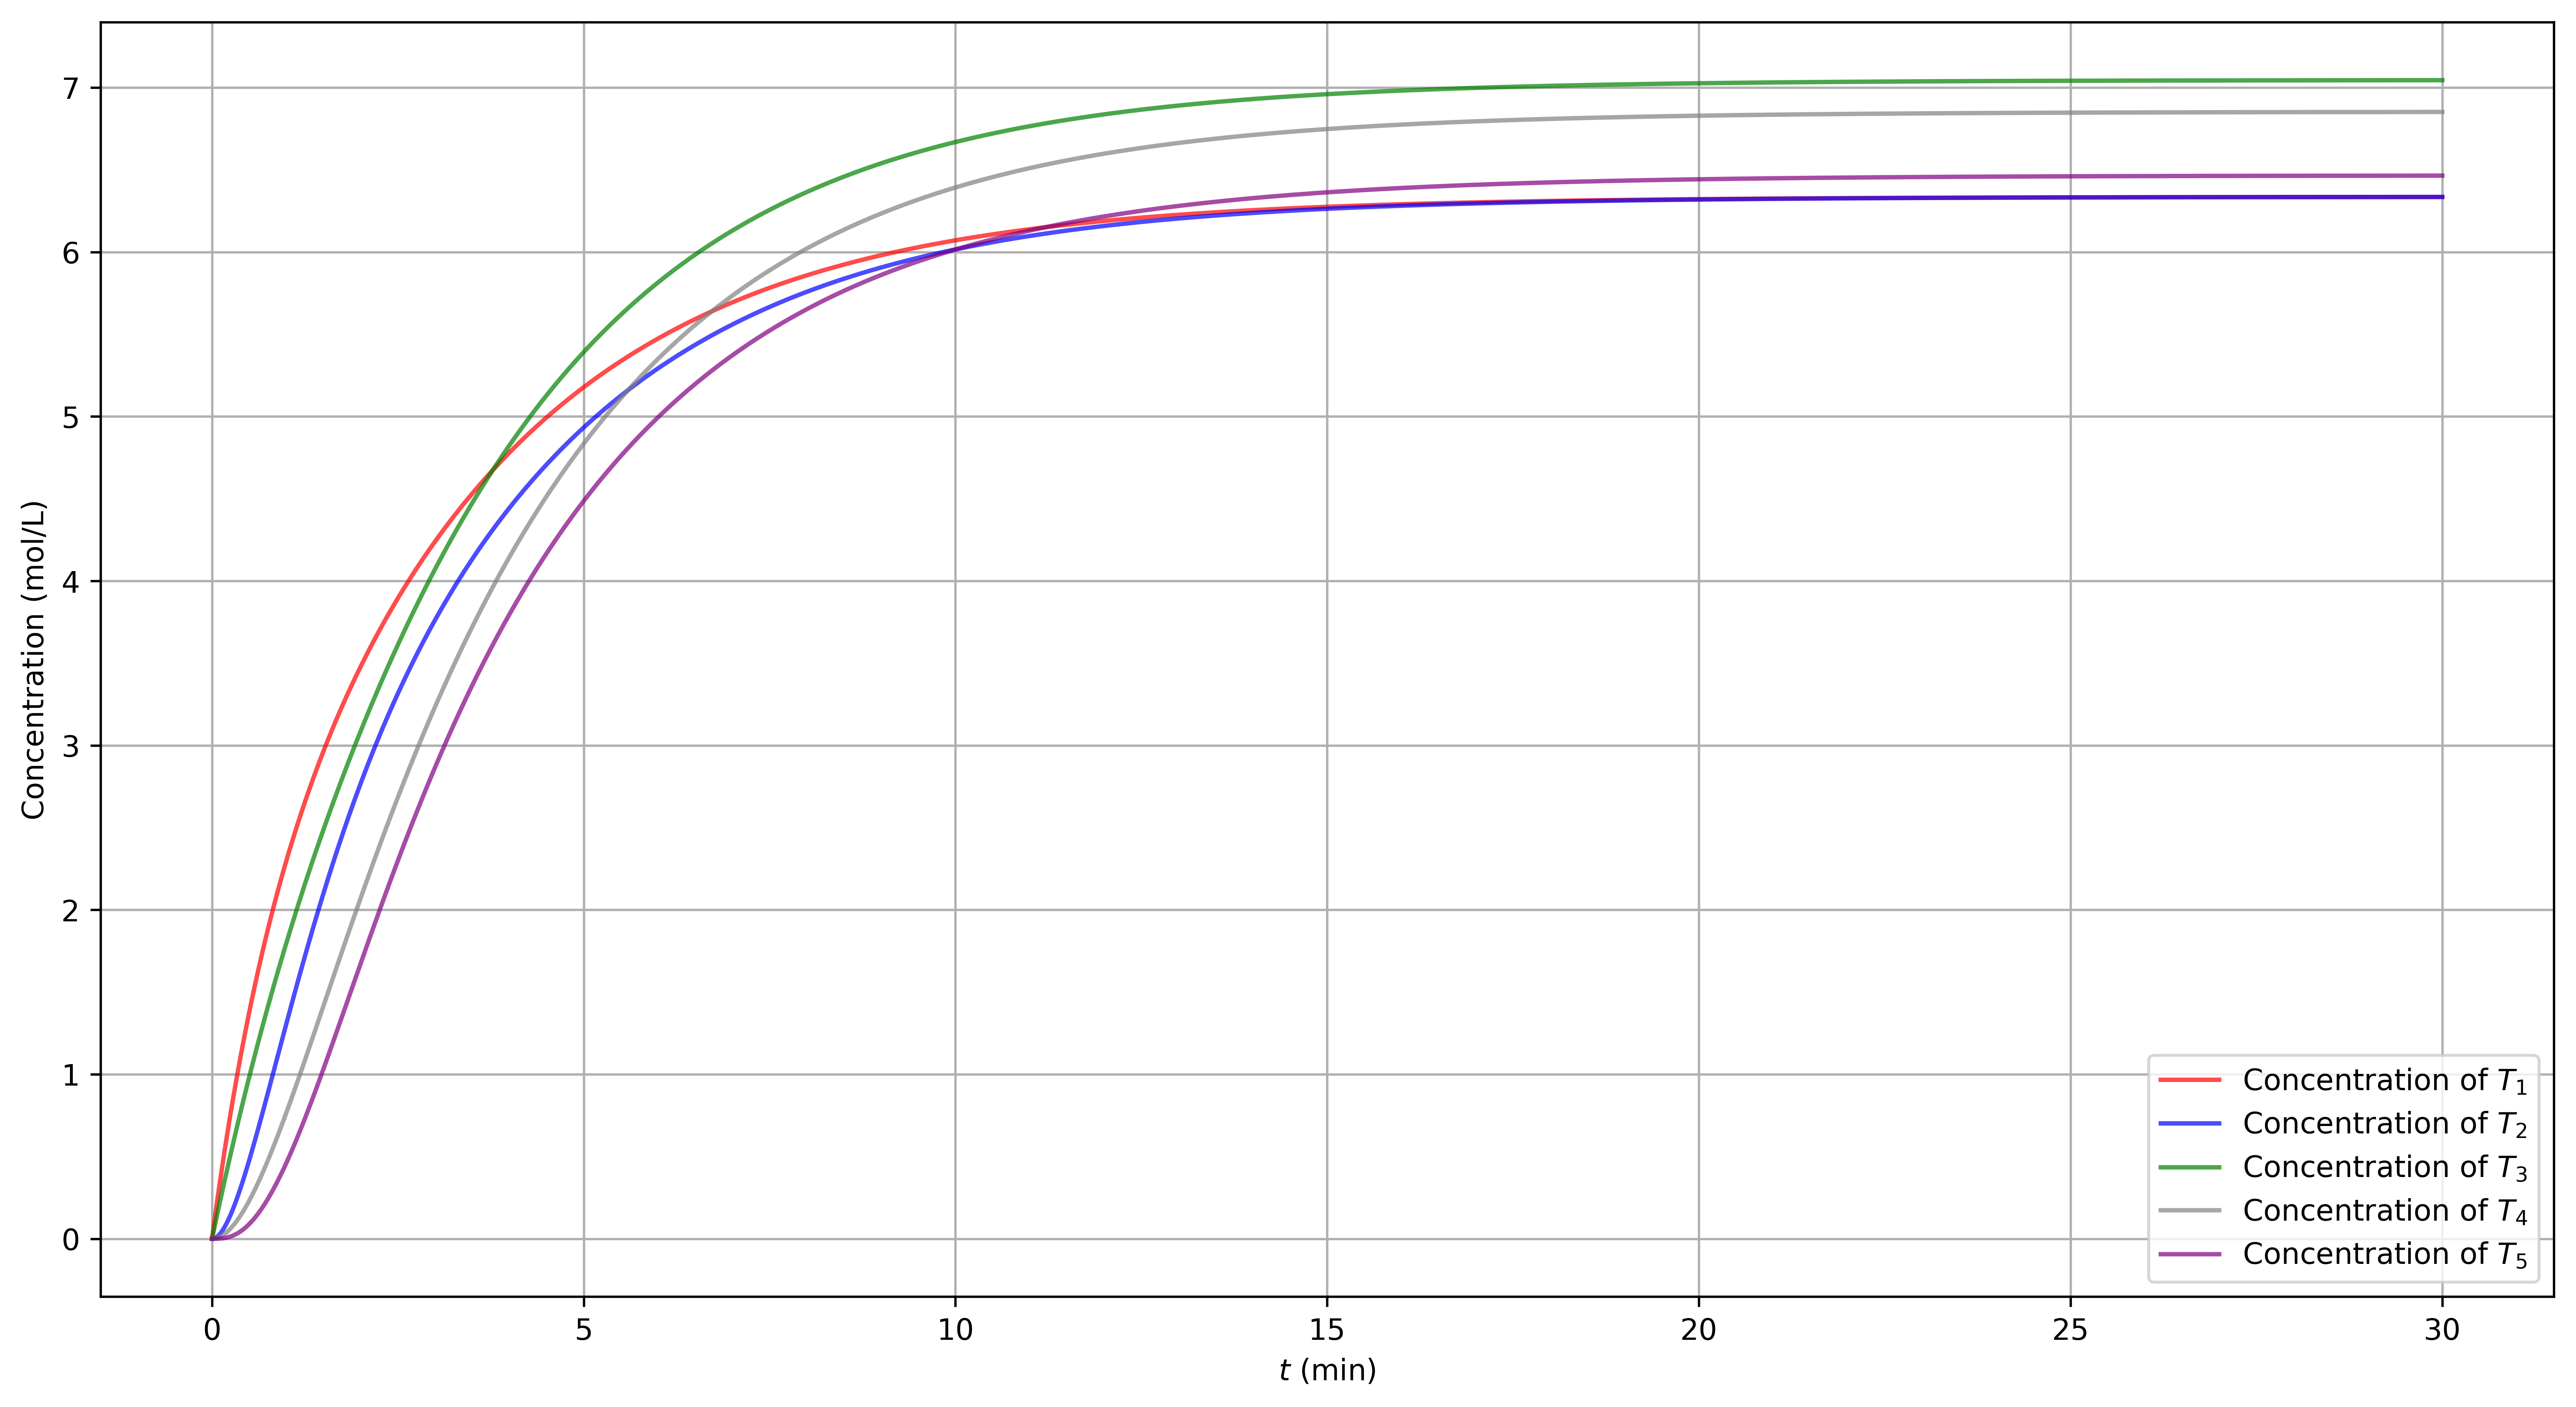

In [5]:
x_range = np.arange(0, t_final+h, h)
create_plot([x_range], [(conc_history[:, 0], conc_history[:, 1], conc_history[:, 2],
                         conc_history[:, 3], conc_history[:, 4])], ["$t$ (min)"],
            ["Concentration (mol/L)"], [("Concentration of $T_1$",
              "Concentration of $T_2$", "Concentration of $T_3$",
              "Concentration of $T_4$", "Concentration of $T_5$")], 
            size=(15, 8), num_rows=1)

# Code D

## Comparing the numerical solution with the steady-state solution

In [6]:
# Final concentration values
c_final = np.asarray([6.33389544688027, 6.3389544688027,
                      7.04342327150084, 6.84991568296796, 6.46290050590219])
# Horizontal lines of the final concentrations
c1_final = np.full(len(x_range), c_final[0])
c2_final = np.full(len(x_range), c_final[1])
c3_final = np.full(len(x_range), c_final[2])
c4_final = np.full(len(x_range), c_final[3])
c5_final = np.full(len(x_range), c_final[4])

create_plot([x_range, x_range, x_range, x_range, x_range],
            [(conc_history[:, 0], c1_final), (conc_history[:, 1], c2_final),
             (conc_history[:, 2], c3_final), (conc_history[:, 3], c4_final),
             (conc_history[:, 4], c5_final)],
            ["$t$ (min)", "$t$ (min)", "$t$ (min)", "$t$ (min)", "$t$ (min)"],
            ["Concentration (mol/L)", "Concentration (mol/L)", "Concentration (mol/L)",
             "Concentration (mol/L)", "Concentration (mol/L)"],
            [("Concentration of $T_1$", "Final Concentration of $T_1$"),
             ("Concentration of $T_2$", "Final Concentration of $T_2$"),
             ("Concentration of $T_3$", "Final Concentration of $T_3$"),
             ("Concentration of $T_4$", "Final Concentration of $T_4$"),
             ("Concentration of $T_5$", "Final Concentration of $T_5$")],
            size=(15, 20), num_rows=5)

## Function definition of the analytical solution to the for the concentration over time

In [7]:
def conc_analytical(time, tank, eigen_vector, eigen_matrix):
    t, i, ev, em = time, tank-1, eigen_vector, eigen_matrix
    pt1 = em[i][0]*np.exp(ev[0]*t)
    pt2 = np.exp(np.real(ev[1])*t)*(em[i][1]*np.cos(np.imag(ev[1])*t)+em[i][2]*np.sin(np.imag(ev[1])*t))
    pt3 = np.exp(np.real(ev[3])*t)*(em[i][3]*np.cos(np.imag(ev[3])*t)+em[i][4]*np.sin(np.imag(ev[3])*t))
    
    return pt1 + pt2 + pt3

## The analytically found Eigenvalues and Eigenmatrices

In [8]:
eigen_vector = np.asarray(
    [-0.34161338483812 + 0j, 
    -2.01213779895561 + 0.679814462137368j, 
    -2.01213779895561 - 0.679814462137368j,
    -1.29674107645811 + 0.62513266343316j,
    -1.29674107645811 - 0.62513266343316j])

eigen_matrix = np.asarray(
    [[-4.624969, -1.268067, .466793, -.440859, .127189],
     [-5.789696, .244898, -3.054389, -.789097, -.690903],
     [-7.026016, -.646325, -.873894, .626964, .261541],
     [-8.900011, 1.988299, 1.047834, .061795, .52500],
     [-8.696338, 1.588736, 2.838709, .644706, -1.388210]])

## Compute the analytical solutions and compare it to the numerical ones

In [9]:
c1_analytical = conc_analytical(x_range, 1, eigen_vector, eigen_matrix)
c1_analytical -= c1_analytical[0]
c2_analytical = conc_analytical(x_range, 2, eigen_vector, eigen_matrix)
c2_analytical -= c2_analytical[0]
c3_analytical = conc_analytical(x_range, 3, eigen_vector, eigen_matrix)
c3_analytical -= c3_analytical[0]
c4_analytical = conc_analytical(x_range, 4, eigen_vector, eigen_matrix)
c4_analytical -= c4_analytical[0]
c5_analytical = conc_analytical(x_range, 5, eigen_vector, eigen_matrix)
c5_analytical -= c5_analytical[0]
create_plot([x_range, x_range, x_range, x_range, x_range],
            [(conc_history[:, 0], c1_analytical), (conc_history[:, 1], c2_analytical),
             (conc_history[:, 2], c3_analytical), (conc_history[:, 3], c4_analytical),
             (conc_history[:, 4], c5_analytical)],
            ["$t$ (min)", "$t$ (min)", "$t$ (min)", "$t$ (min)", "$t$ (min)"],
            ["Concentration (mol/L)", "Concentration (mol/L)", "Concentration (mol/L)",
             "Concentration (mol/L)", "Concentration (mol/L)"],
            [("Concentration of T1", "Analytical Concentration of T1"),
             ("Concentration of T2", "Analytical Concentration of T2"),
             ("Concentration of T3", "Analytical Concentration of T3"),
             ("Concentration of T4", "Analytical Concentration of T4"),
             ("Concentration of T5", "Analytical Concentration of T5"),], size=(15, 20), num_rows=5)